# I'm Something of a Painter Myself (CSCA-5642 Week5)
This project will explore generating Monet style images using GAN (Generative Adversarial Network).  

We will explore using DCGAN (Deep Convolutional Generative Adversarial Network) to purely generate Monet-style images from scratch.

## Exploratory Data Analysis

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
import tensorflow as tf

In [ ]:
# If Running in Kaggle. Input, Output, working directories must be updated
# ALso, some data like sample data and graphs files save can be skipped
IS_KAGGLE = True

### Dataset Properties

In [ ]:

INPUT_PATH = '/kaggle/input/gan-getting-started' if IS_KAGGLE else './gan-getting-started'
print(os.listdir(INPUT_PATH))

monet_count = len(os.listdir(INPUT_PATH + '/monet_jpg'))
photo_count = len(os.listdir(INPUT_PATH + '/photo_jpg'))
print(f"Number of Monet paintings: {monet_count}")
print(f"Number of photos: {photo_count}")

['monet_jpg', 'monet_tfrec', 'photo_jpg', 'photo_tfrec']
Number of Monet paintings: 300
Number of photos: 7038


We have 300 monet images and 7038 normal photos

In [21]:
sample_file = os.listdir(INPUT_PATH + '/monet_jpg')[0]
img = Image.open(INPUT_PATH + '/monet_jpg/' + sample_file)
print(img.size)

(256, 256)


Images are composed as 256 by 256 pixels

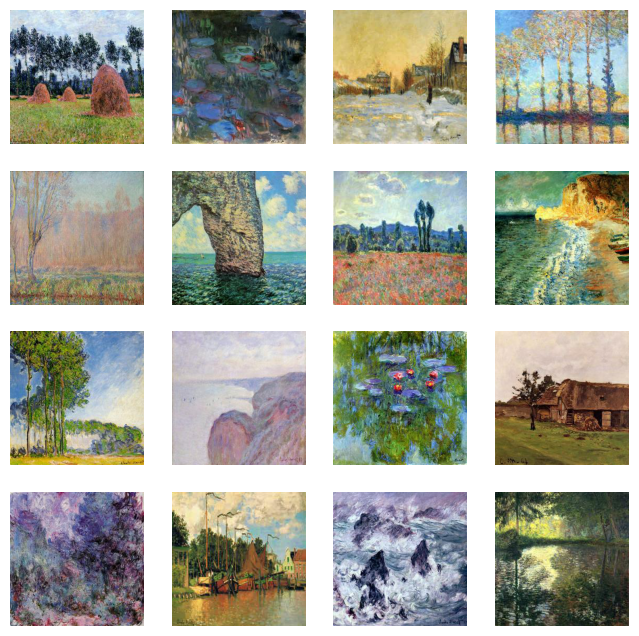

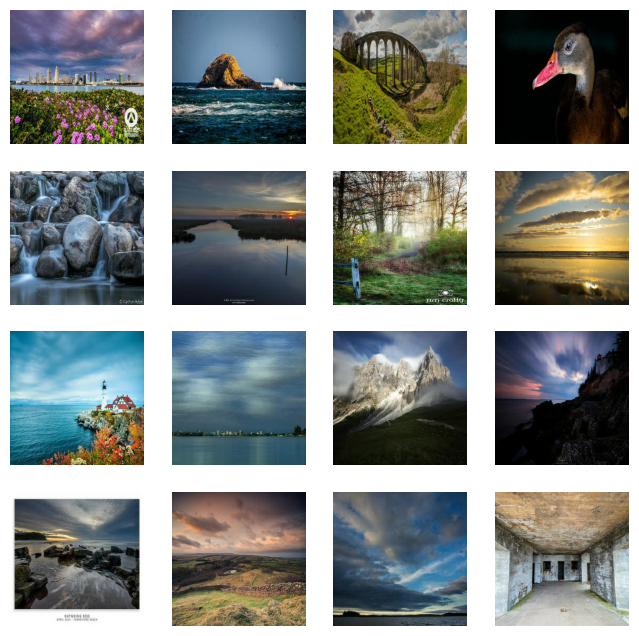

In [20]:
def display_sample_images(directory, n=4, cols=4):
    plt.figure(figsize=(8, 8))
    
    sample_size = n * cols
    
    files = np.random.choice(os.listdir(directory), sample_size)
    for i, file in enumerate(files):
        img = Image.open(os.path.join(directory, file))
        plt.subplot(n, cols, i+1)
        plt.imshow(img)
        plt.axis('off')
    
    plt.show()

# Display sample Monet paintings
display_sample_images(INPUT_PATH + '/monet_jpg')

# Display sample photos
display_sample_images(INPUT_PATH + '/photo_jpg')

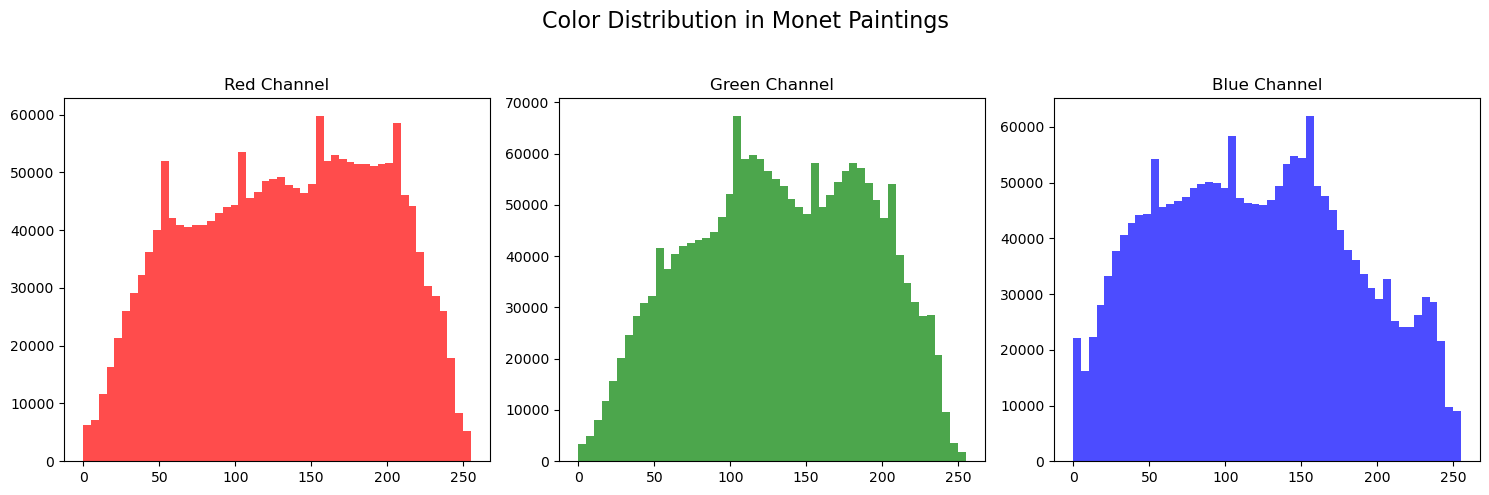

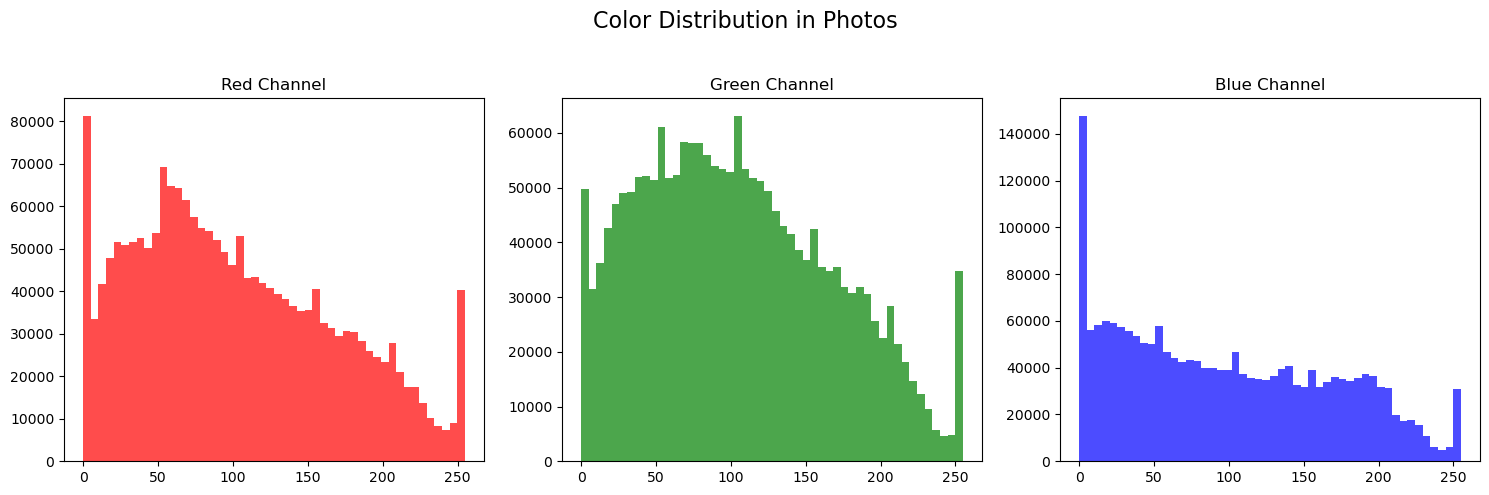

In [ ]:
def analyze_color_distribution(directory, title):
    plt.figure(figsize=(15, 5))
    plt.suptitle(title)
    
    # Collect color data from 30 random images
    r_values, g_values, b_values = [], [], []
    files = np.random.choice(os.listdir(directory), 30)
    
    for file in files:
        img = np.array(Image.open(os.path.join(directory, file)))
        r_values.extend(img[:,:,0].flatten())
        g_values.extend(img[:,:,1].flatten())
        b_values.extend(img[:,:,2].flatten())
    
    # Plot RGB histograms
    plt.subplot(1, 3, 1)
    plt.hist(r_values, bins=50, color='red', alpha=0.7)
    plt.title('Red Channel')
    
    plt.subplot(1, 3, 2)
    plt.hist(g_values, bins=50, color='green', alpha=0.7)
    plt.title('Green Channel')
    
    plt.subplot(1, 3, 3)
    plt.hist(b_values, bins=50, color='blue', alpha=0.7)
    plt.title('Blue Channel')
    
    plt.show()

# Analyze Monet paintings
analyze_color_distribution(INPUT_PATH + '/monet_jpg', 'Color Distribution in Monet Paintings')

# Analyze photos (for comparison)
analyze_color_distribution(INPUT_PATH + '/photo_jpg', 'Color Distribution in Photos')

In [14]:
def compute_image_statistics(directory, sample_size=50):
    # Select random sample of images
    files = np.random.choice(os.listdir(directory), sample_size)
    
    brightness_values = []
    contrast_values = []
    saturation_values = []
    
    for file in files:
        img = np.array(Image.open(os.path.join(directory, file))) / 255.0
        
        # Calculate brightness (mean pixel value)
        brightness = np.mean(img)
        brightness_values.append(brightness)
        
        # Calculate contrast (standard deviation)
        contrast = np.std(img)
        contrast_values.append(contrast)
        
        # Calculate saturation
        r, g, b = img[:,:,0], img[:,:,1], img[:,:,2]
        saturation = np.mean(np.max(np.stack([r, g, b]), axis=0) - np.min(np.stack([r, g, b]), axis=0))
        saturation_values.append(saturation)
    
    return {
        'brightness': brightness_values,
        'contrast': contrast_values,
        'saturation': saturation_values
    }

# Compute statistics for both sets
monet_stats = compute_image_statistics(INPUT_PATH + '/monet_jpg')
photo_stats = compute_image_statistics(INPUT_PATH + '/photo_jpg')

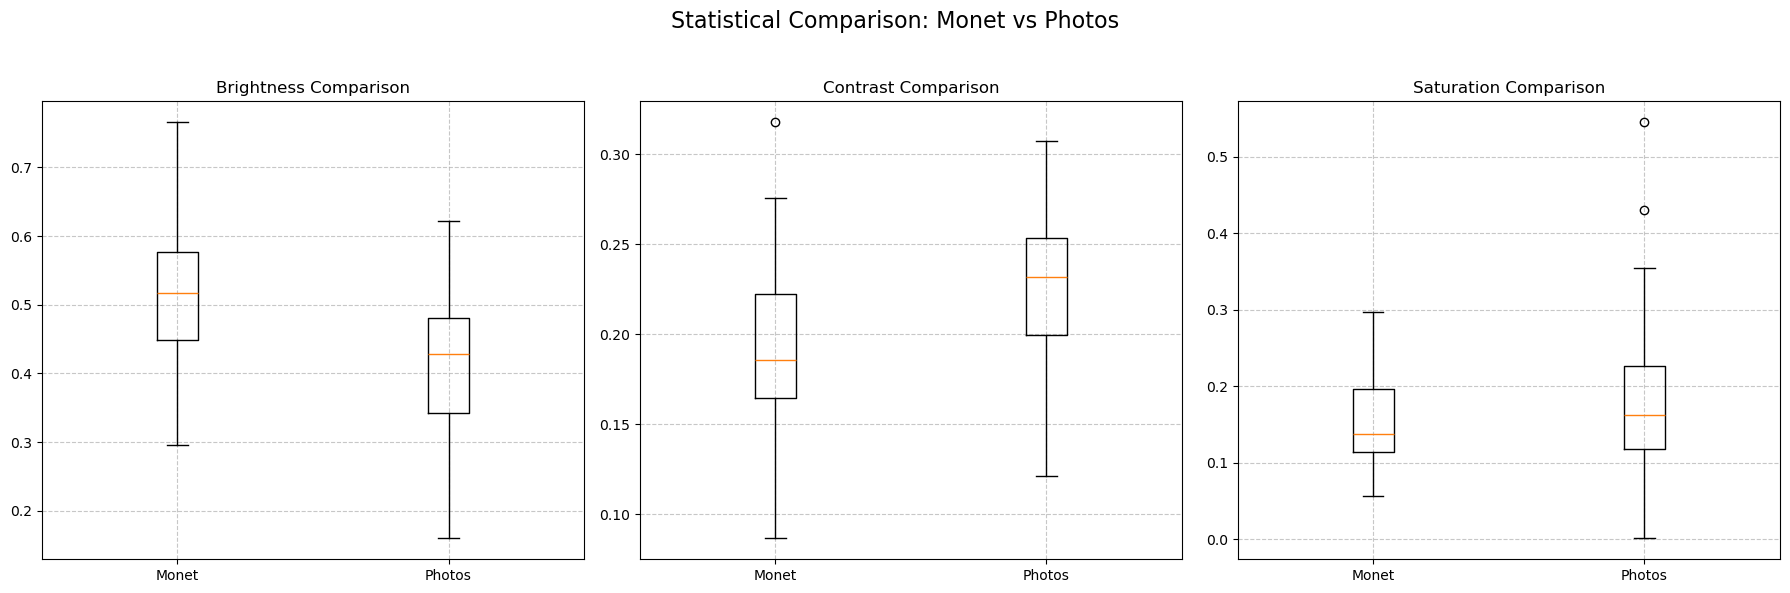

In [13]:
# Create comparison box plots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Statistical Comparison: Monet vs Photos', fontsize=16)

for i, metric in enumerate(['brightness', 'contrast', 'saturation']):
    axs[i].boxplot([monet_stats[metric], photo_stats[metric]], labels=['Monet', 'Photos'])
    axs[i].set_title(f'{metric.capitalize()} Comparison')
    axs[i].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

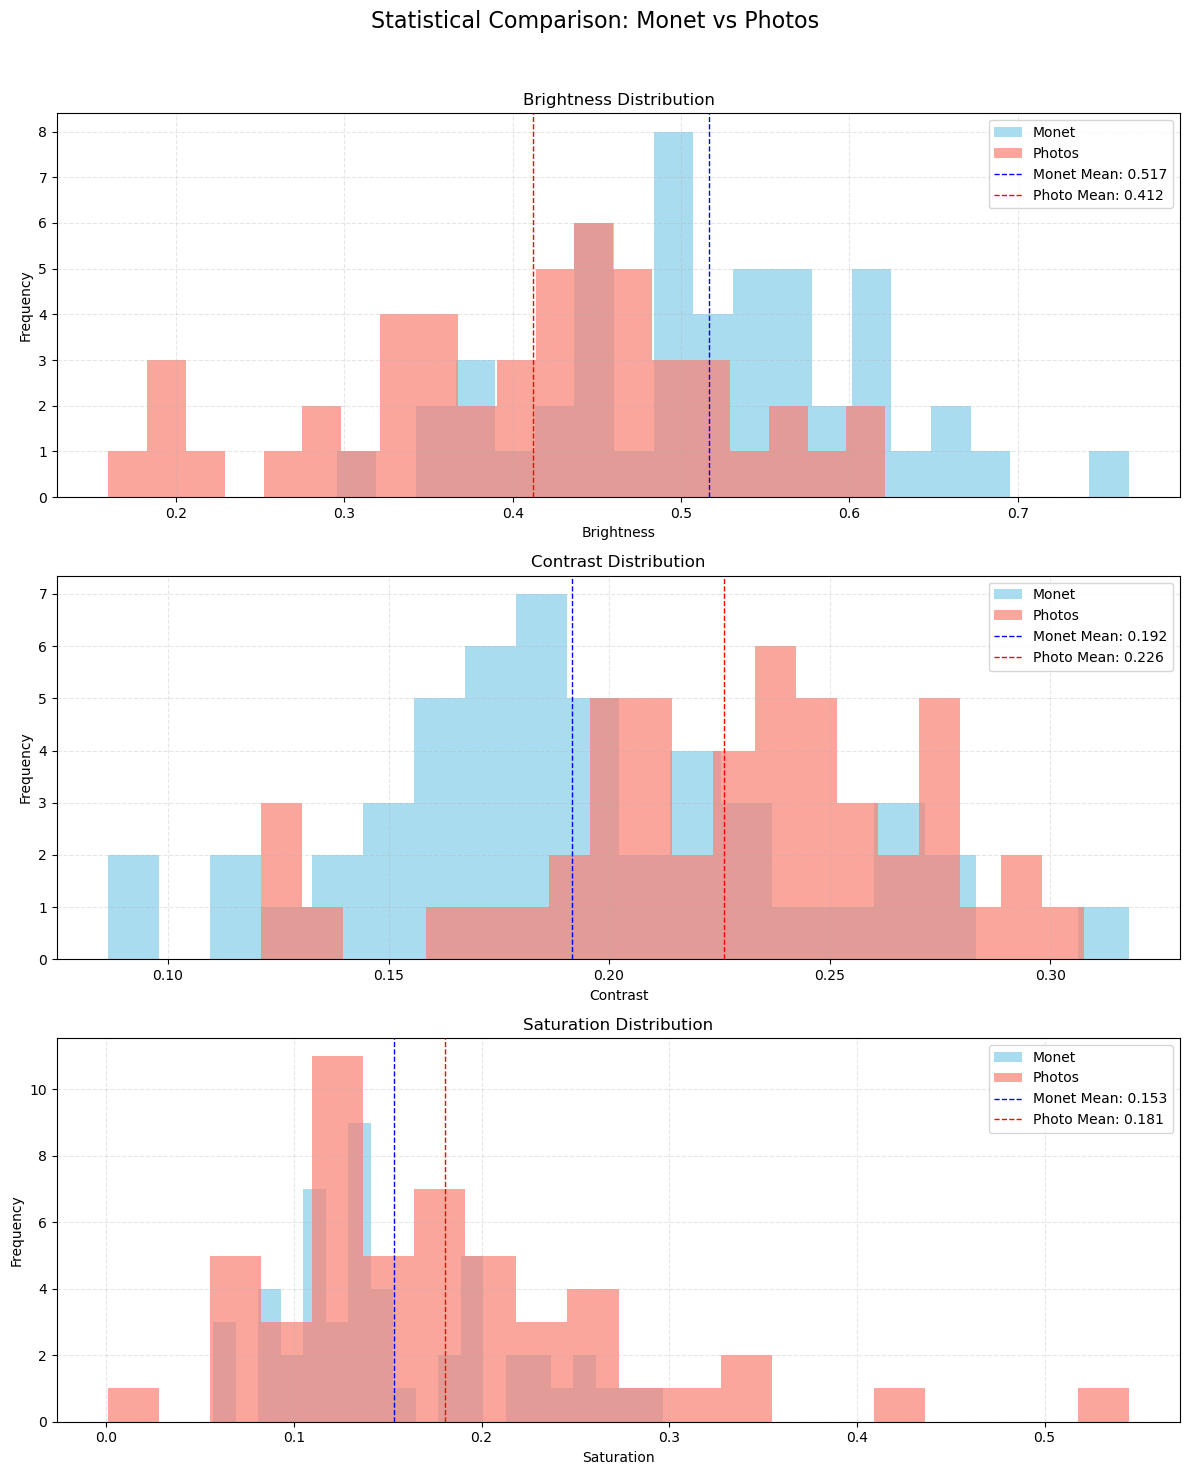

In [12]:
def plot_image_statistics_histograms(monet_stats, photo_stats):
    metrics = ['brightness', 'contrast', 'saturation']
    fig, axs = plt.subplots(3, 1, figsize=(12, 15))
    fig.suptitle('Statistical Comparison: Monet vs Photos', fontsize=16)
    
    for i, metric in enumerate(metrics):
        # Plot histograms on the same axis
        axs[i].hist(monet_stats[metric], bins=20, alpha=0.7, label='Monet', color='skyblue')
        axs[i].hist(photo_stats[metric], bins=20, alpha=0.7, label='Photos', color='salmon')
        
        # Add vertical lines for means
        monet_mean = np.mean(monet_stats[metric])
        photo_mean = np.mean(photo_stats[metric])
        axs[i].axvline(monet_mean, color='blue', linestyle='dashed', linewidth=1, label=f'Monet Mean: {monet_mean:.3f}')
        axs[i].axvline(photo_mean, color='red', linestyle='dashed', linewidth=1, label=f'Photo Mean: {photo_mean:.3f}')
        
        # Add labels and legend
        axs[i].set_title(f'{metric.capitalize()} Distribution')
        axs[i].set_xlabel(metric.capitalize())
        axs[i].set_ylabel('Frequency')
        axs[i].legend()
        axs[i].grid(True, linestyle='--', alpha=0.3)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Compute statistics if not already computed
if 'monet_stats' not in locals():
    monet_stats = compute_image_statistics(INPUT_PATH + '/monet_jpg')
    photo_stats = compute_image_statistics(INPUT_PATH + '/photo_jpg')

# Plot histograms
plot_image_statistics_histograms(monet_stats, photo_stats)

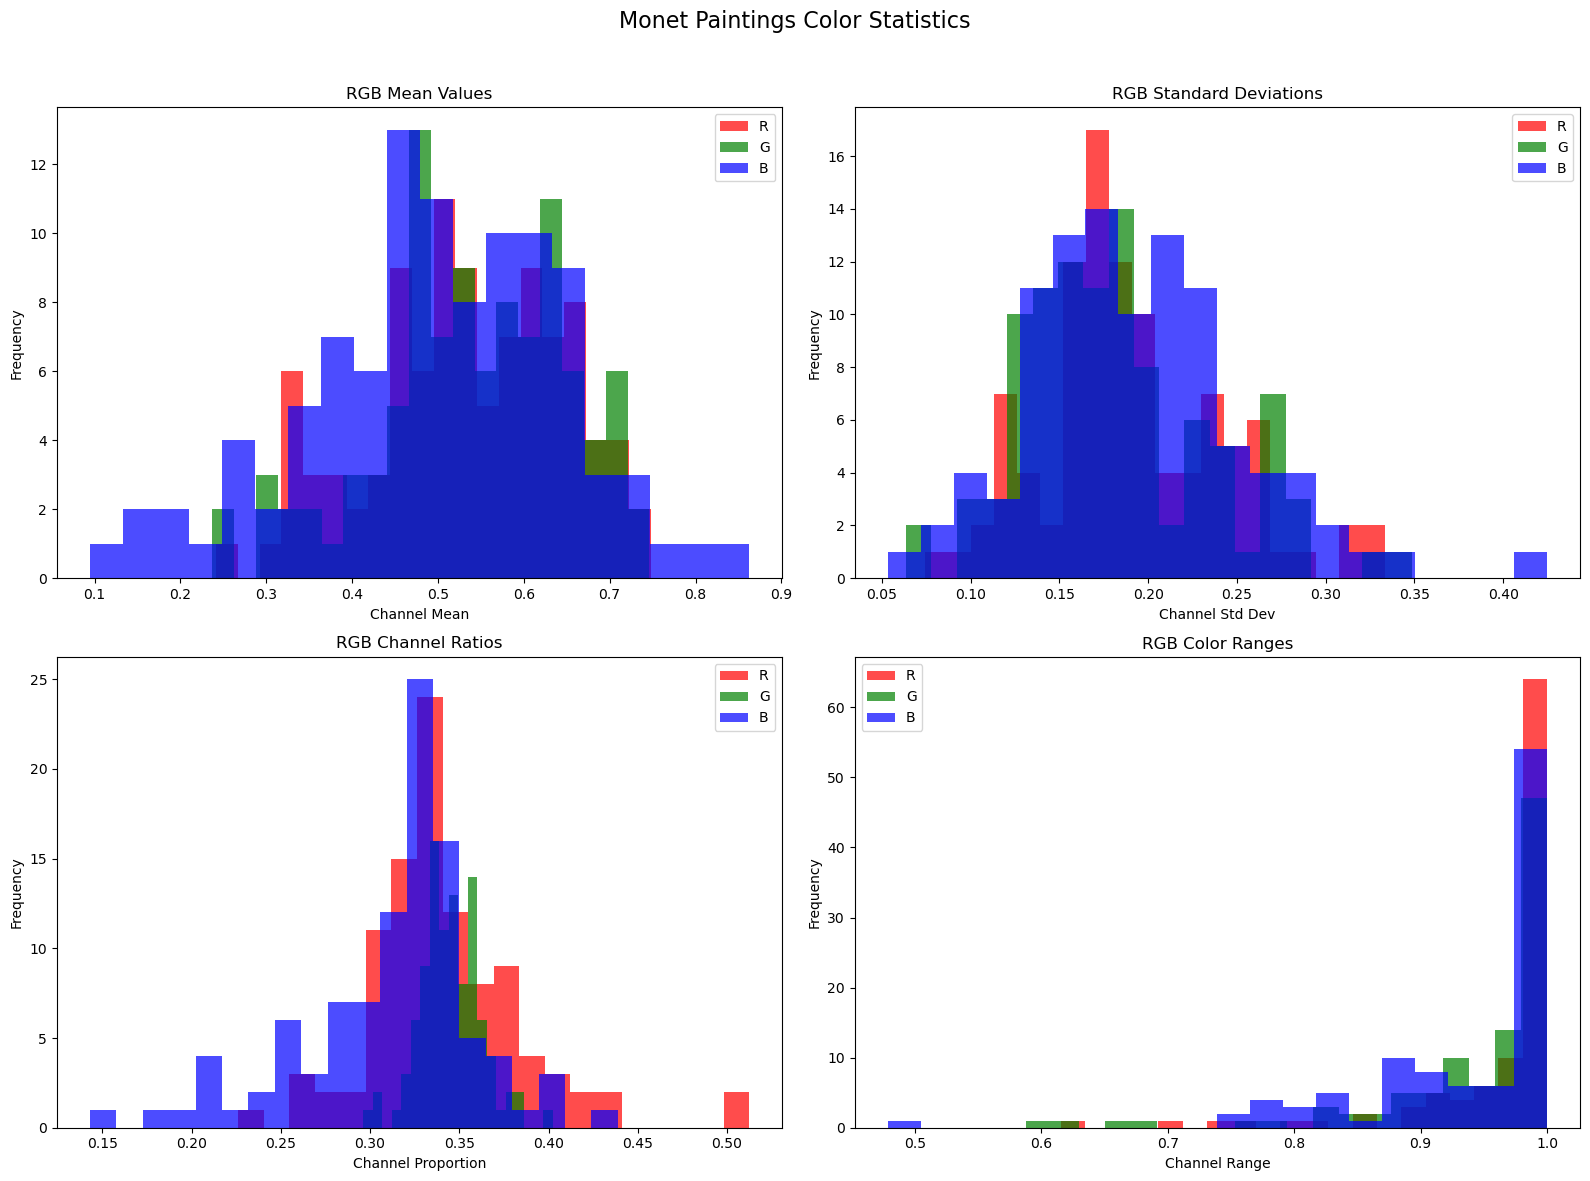

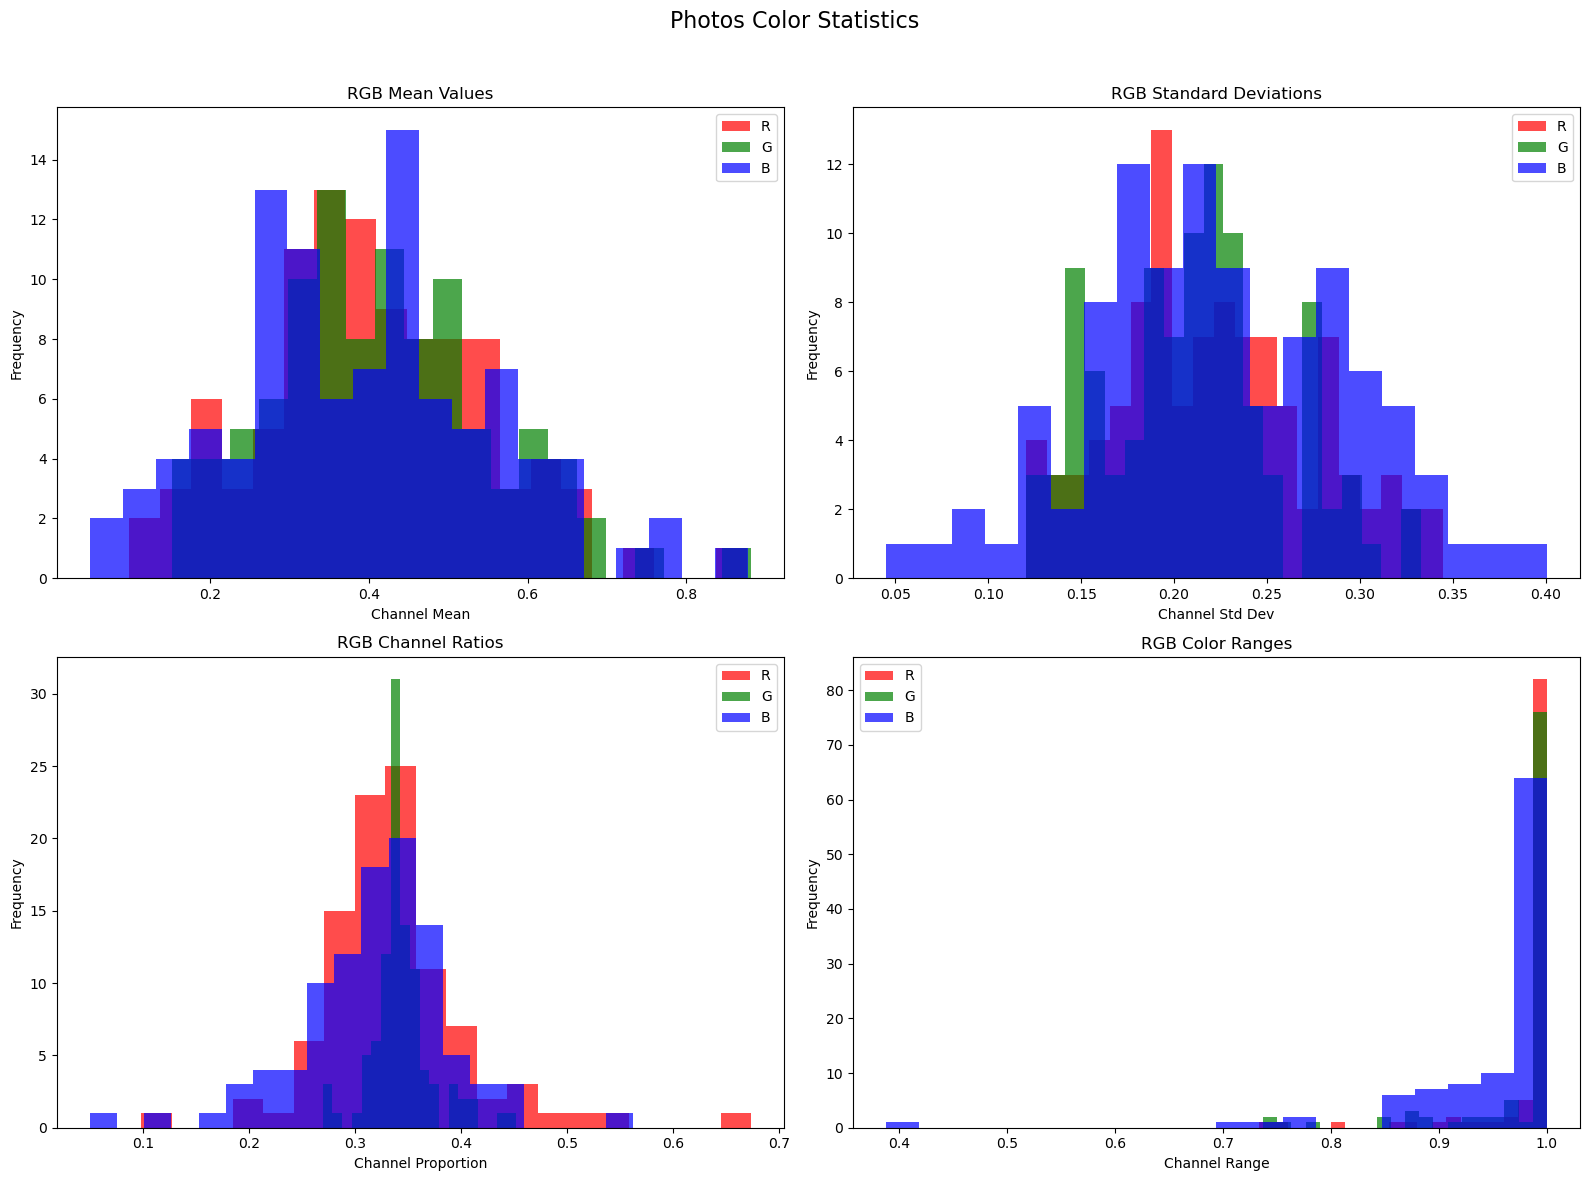

=== Color Statistics Comparison ===
RGB Channel Means:
  Monet: R=0.533, G=0.541, B=0.498
  Photos: R=0.406, G=0.418, B=0.394

RGB Channel Std Devs:
  Monet: R=0.191, G=0.182, B=0.192
  Photos: R=0.222, G=0.210, B=0.225

RGB Channel Ratios:
  Monet: R=0.343, G=0.345, B=0.312
  Photos: R=0.337, G=0.344, B=0.319


Dominant Colors in Monet Paintings:


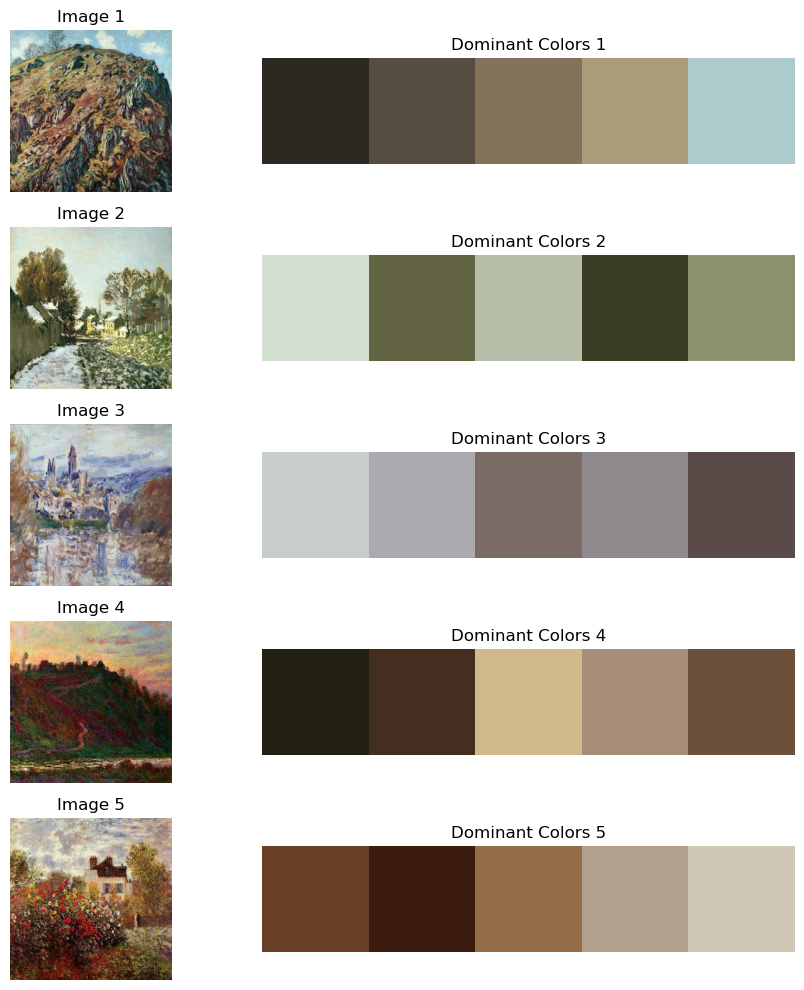

Dominant Colors in Photos:


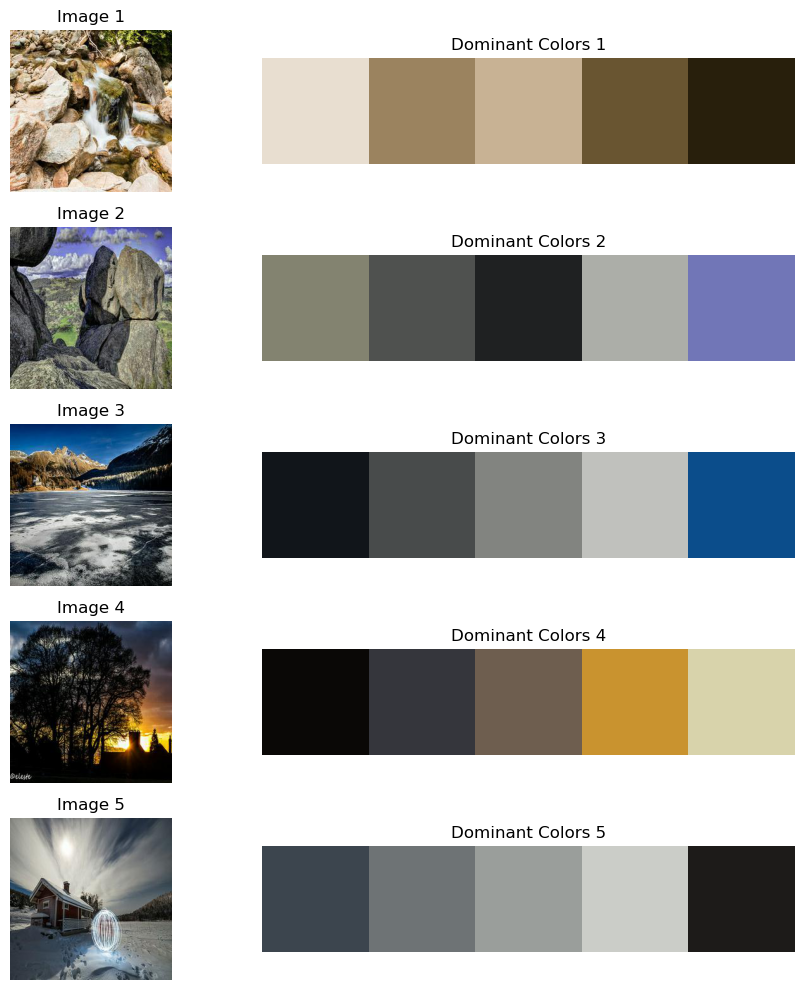

In [19]:
def extract_dominant_colors(directory, n_samples=5, n_colors=5):
    from sklearn.cluster import KMeans
    
    # Sample files
    all_files = os.listdir(directory)
    files = np.random.choice(all_files, min(n_samples, len(all_files)), replace=False)
    
    plt.figure(figsize=(10, 10))
    
    for i, file in enumerate(files):
        # Load image
        img_path = os.path.join(directory, file)
        img = np.array(Image.open(img_path))
        
        # Reshape for clustering
        pixels = img.reshape(-1, 3)
        
        # Apply KMeans to find dominant colors
        kmeans = KMeans(n_clusters=n_colors, n_init=10)
        kmeans.fit(pixels)
        colors = kmeans.cluster_centers_.astype(int)
        
        # Sort colors by occurrence (highest first)
        counts = np.bincount(kmeans.labels_)
        colors = colors[np.argsort(-counts)]
        
        # Display image
        plt.subplot(n_samples, 2, 2*i+1)
        plt.imshow(img)
        plt.title(f"Image {i+1}")
        plt.axis('off')
        
        # Display color palette
        plt.subplot(n_samples, 2, 2*i+2)
        plt.imshow([colors/255])
        plt.title(f"Dominant Colors {i+1}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Extract dominant colors from Monet paintings
print("Dominant Colors in Monet Paintings:")
extract_dominant_colors(INPUT_PATH + '/monet_jpg')

# Extract dominant colors from photos
print("Dominant Colors in Photos:")
extract_dominant_colors(INPUT_PATH + '/photo_jpg')

## Building The Pure Generation Model through GAN

Here are all the different issues that I ran into.

### Issue 1: with CPU Based Training

Because the complexity of the model, (even with the simplest version of the model) the training would take more than 1 hour.  Through trial and error, as the complexity of the model were increased, it would take more than 2 hours to train the model.  This presented significant risk.  So I looked into using the GPU on my desktop using the Nvidia CUDA platform.

### Environment Set up
We will set up to use GPU as this is a heavy resource intensive model.

#### Machine
- Nvidia GeForce RTX 2060 6GB (Released 2020)

#### Software Environment
- Python 3.10.1
- Tensorflow 2.10
- CUDA 11.8
- cuDNN 8.1.1

CUDA (Compute Unified Device Architecture) is a parallel computing platform and programming model developed by NVIDIA. It allows developers to use NVIDIA GPUs for general-purpose processing (GPGPU)

cuDNN (CUDA Deep Neural Network library) is a GPU-accelerated library specifically designed for deep learning operations. It's built on top of CUDA and provides highly optimized implementations for common deep learning operations such as:

- Convolutions
- Pooling
- Normalization
- Activation functions
- Tensor transformations



### Issue 2: with GPU Based Training

With the GPU Based training, I was able to get the training time from 2-4 hours to 30-60 minutes.  However, the main constraint now became the GPU memory, with only 6GB that was available with my old GPU, as the complexity of the model grew, I had trouble fitting all the parameters.  So I had to reduce my batch size down to only 10 images at a time.

While reducing the batch size can help fit the size of the training data, it can also introduce sensitivity in training which can lead to overall instability of the model.


### Issue 3: checkerboard pattern

While I was training, I kept getting the checkerboard pattern in the generation images.

![image](./samples_5x5/image_at_epoch_0080.png)

This is due to using the transposed convolutions for upsampling `layers.Conv2DTranspose` because of the strided convolution and a large kernel size.

#### Reduce checkerboard patterns

Instead of always using `Conv2DTranspose` I was able to mix in each layer that used `UpSampling2D` that has the smoothing factor.  Mainly, I used `bilinear` appoach that smooths out using the interpolation of neighboring pixels.

However, when I completely replaced `Conv2DTranspose` with `UpSampling2D`, it resulted in too smooth of transition that would not work for Monet sytle painting.

![image](./sample_upsampling/image_at_epoch_0038.png)

#### Using Both Conv2DTranspose AND UpSampling2D
By using both `Conv2DTranspose` and `UpSampling2D`, I was finally able to get to a proper level of smoothing out the checker board pattern while still keeping the noise level of Monet style painting

![image](./samples_dense_discriminator/image_at_epoch_0150.png)


### Issue 4: Model Collapsing.  Unbalanced Losss between Generator and Discriminator Model

In DCGAN (Deep Convolutional Generative Adversarial Network), the generator and discriminator must perform and compete with each other without one outperforming another.

As I was focused on improving the performance of the generator model, it way over-performed the discriminator where discriminator's loss was sporatic and often very high.

So I added another `Dense` layer on the discriminator.

But, now it was again the Generator model that outperformed the Discriminator.  In order to reduce the unbalance, I used regularization techniques such as increasing the Dropout to Discriminator to even out the performance.


### Issue 4B: Adjusting Learning Rate

Even with regularization, Discriminator continued to outperform Generator, 

![image](./training_losses_dense_discriminator.png)

In order to slow down the Discriminator, I applied lower learning rate to Discriminator from 0.0001 -> 0.00005.

Also, we added a 15% random skipping of applying the gradient learning only on the Discriminator.  The result was much better adversarial model. 

![image](./training_losses_with_slow_discriminator.png)

### Issue 5: Submission to Kaggle

After training the model on my GPU, I was able to create great looking Monet style images.  However, I did not realize the Kaggle notebook did not allow the setting to enable the GPU.  After running my notebook for 11 hours. It was cancelled.  

Here are some sample images from the model.

![image](./samples_my_best_model/image_at_epoch_0149.png)

This meant, I had to alter my existing model to use less parameters.

#### Changes To Apply
- Suppress any unncessary logs
- Increase batch size from 10 to 50 (since it should not be bound by memory anymore)
- Reduce Epoch from 150 to 100
- Reduce Generator Training complexity from 27 million parameters to
- 


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
import zipfile
from PIL import Image
import glob
import time

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 50 if IS_KAGGLE else 10

def load_monet_images(image_dir):
    monet_files = glob.glob(f"{image_dir}/monet_jpg/*.jpg")
    
    print(f"Found {len(monet_files)} Monet paintings")
    
    monet_dataset = tf.data.Dataset.from_tensor_slices(monet_files)
    
    # Map preprocessing function to dataset
    monet_dataset = monet_dataset.map(preprocess_image)
    
    # Shuffle and batch
    monet_dataset = monet_dataset.shuffle(len(monet_files)).batch(BATCH_SIZE)
    
    return monet_dataset

def preprocess_image(image_path):
    # Read image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    
    # Resize to target dimensions
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    
    # Normalize to [-1, 1] range
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    
    return image

In [3]:
LATENT_DIM = 100

# def build_generator():
#     # Specialized initializer for GANs
#     initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    
#     model = keras.Sequential([
#         # Input layer for noise vector
#         layers.Input(shape=(LATENT_DIM,)),
        
#         # First dense layer to convert noise to 3D tensor with greater capacity
#         layers.Dense(8 * 8 * 1024, kernel_initializer=initializer),
#         layers.BatchNormalization(),
#         layers.LeakyReLU(0.2),
#         layers.Reshape((8, 8, 1024)),
        
#         # First upsampling block (8x8 → 16x16)
#         layers.Conv2DTranspose(512, (5, 5), strides=(2, 2), padding='same', 
#                               kernel_initializer=initializer),
#         layers.BatchNormalization(),
#         layers.LeakyReLU(0.2),
        
#         # Second upsampling block (16x16 → 32x32)
#         layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same',
#                               kernel_initializer=initializer),
#         layers.BatchNormalization(),
#         layers.LeakyReLU(0.2),
        
#         # Third upsampling block (32x32 → 64x64)
#         layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same',
#                               kernel_initializer=initializer),
#         layers.BatchNormalization(),
#         layers.LeakyReLU(0.2),
        
#         # Fourth upsampling block (64x64 → 128x128)
#         layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same',
#                               kernel_initializer=initializer),
#         layers.BatchNormalization(),
#         layers.LeakyReLU(0.2),
        
#         # Fifth upsampling block (128x128 → 256x256)
#         layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same',
#                               kernel_initializer=initializer),
#         layers.BatchNormalization(),
#         layers.LeakyReLU(0.2),
        
#         # Refinement layers for better texture detail
#         layers.Conv2D(32, (3, 3), padding='same', kernel_initializer=initializer),
#         layers.BatchNormalization(),
#         layers.LeakyReLU(0.2),
        
#         # Another refinement layer
#         layers.Conv2D(32, (3, 3), padding='same', kernel_initializer=initializer),
#         layers.BatchNormalization(),
#         layers.LeakyReLU(0.2),
        
#         # Output layer with tanh activation for pixel values in [-1, 1]
#         # Larger kernel for final layer to capture more spatial context
#         layers.Conv2D(3, (5, 5), padding='same', activation='tanh',
#                      kernel_initializer=initializer),
#     ])
    
#     return model

# # Improved upsampling block to reduce checkerboard artifacts
# def upsample_block(x, filters, kernel_size=5):
#     # Use UpSampling2D + Conv2D instead of Conv2DTranspose
#     x = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(x)
#     x = layers.Conv2D(filters, kernel_size, padding='same',
#                      kernel_initializer=tf.random_normal_initializer(0., 0.02))(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.LeakyReLU(0.2)(x)
#     return x

# # Residual block implementation
# def residual_block(x, filters, kernel_size=3):
#     shortcut = x
    
#     x = layers.Conv2D(filters, kernel_size, padding='same', 
#                      kernel_initializer=tf.random_normal_initializer(0., 0.02))(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.LeakyReLU(0.2)(x)
    
#     x = layers.Conv2D(filters, kernel_size, padding='same',
#                      kernel_initializer=tf.random_normal_initializer(0., 0.02))(x)
#     x = layers.BatchNormalization()(x)
    
#     # Add skip connection
#     return layers.add([shortcut, x])

# # Improved generator model
# def build_generator():
#     # Specialized initializer for GANs
#     initializer = tf.random_normal_initializer(0., 0.02)
    
#     # Input layer for noise vector
#     noise_input = layers.Input(shape=(LATENT_DIM,))
    
#     # First dense layer to convert noise to 3D tensor
#     x = layers.Dense(8 * 8 * 1024, kernel_initializer=initializer)(noise_input)
#     x = layers.BatchNormalization()(x)
#     x = layers.LeakyReLU(0.2)(x)
#     x = layers.Reshape((8, 8, 1024))(x)
    
#     # Upsampling blocks using improved method
#     # 8x8 → 16x16
#     x = upsample_block(x, 512)
    
#     # 16x16 → 32x32
#     x = upsample_block(x, 256)
    
#     # 32x32 → 64x64
#     x = upsample_block(x, 128)
    
#     # 64x64 → 128x128
#     x = upsample_block(x, 64)
    
#     # 128x128 → 256x256
#     x = upsample_block(x, 32)
    
#     # Add residual blocks for refinement
#     x = residual_block(x, 32)
#     x = residual_block(x, 32)
    
#     # Final output layer
#     x = layers.Conv2D(3, 5, padding='same', activation='tanh',
#                      kernel_initializer=initializer)(x)
    
#     # Create and return model
#     model = keras.Model(inputs=noise_input, outputs=x)
#     return model


# # Improved upsampling block that preserves painterly texture
# def upsample_block(x, filters, kernel_size=5, add_noise=True, use_nearest=False):
#     # Choose interpolation method - nearest preserves more texture
#     interp_method = 'nearest' if use_nearest else 'bilinear'
    
#     # Use UpSampling2D + Conv2D instead of Conv2DTranspose
#     x = layers.UpSampling2D(size=(2, 2), interpolation=interp_method)(x)
    
#     # Add controlled noise to simulate brush texture
#     if add_noise:
#         noise_strength = 0.03  # Subtle noise for texture
#         noise = tf.random.normal(tf.shape(x), 0, noise_strength)
#         x = x + noise
    
#     # Apply convolution with slightly smaller kernel to preserve detail
#     x = layers.Conv2D(filters, kernel_size, padding='same',
#                      kernel_initializer=tf.random_normal_initializer(0., 0.02))(x)
#     x = layers.BatchNormalization(momentum=0.8)(x)  # Lower momentum preserves more variation
#     x = layers.LeakyReLU(0.2)(x)
    
#     # Add a detail-enhancing layer with smaller kernel
#     x = layers.Conv2D(filters, 3, padding='same',
#                      kernel_initializer=tf.random_normal_initializer(0., 0.02))(x)
#     x = layers.BatchNormalization(momentum=0.8)(x)
#     x = layers.LeakyReLU(0.2)(x)
    
#     return x

# # Residual block implementation - modified to preserve texture
# def residual_block(x, filters, kernel_size=3):
#     shortcut = x
    
#     # First convolutional layer
#     x = layers.Conv2D(filters, kernel_size, padding='same', 
#                      kernel_initializer=tf.random_normal_initializer(0., 0.02))(x)
#     x = layers.BatchNormalization(momentum=0.8)(x)
#     x = layers.LeakyReLU(0.2)(x)
    
#     # Second convolutional layer
#     x = layers.Conv2D(filters, kernel_size, padding='same',
#                      kernel_initializer=tf.random_normal_initializer(0., 0.02))(x)
#     x = layers.BatchNormalization(momentum=0.8)(x)
    
#     # Add skip connection with a scale factor to control smoothness
#     x = layers.Lambda(lambda inputs: inputs[0] * 0.8 + inputs[1])([x, shortcut])
#     return x

# # Improved generator model that preserves painterly characteristics
# def build_generator():
#     # Specialized initializer for GANs
#     initializer = tf.random_normal_initializer(0., 0.02)
    
#     # Input layer for noise vector
#     noise_input = layers.Input(shape=(LATENT_DIM,))
    
#     # First dense layer to convert noise to 3D tensor
#     x = layers.Dense(8 * 8 * 1024, kernel_initializer=initializer)(noise_input)
#     x = layers.BatchNormalization(momentum=0.8)(x)
#     x = layers.LeakyReLU(0.2)(x)
#     x = layers.Reshape((8, 8, 1024))(x)
    
#     # Add initial noise for texture variation
#     noise = tf.random.normal(tf.shape(x), 0, 0.05)
#     x = x + noise
    
#     # Upsampling blocks using improved method with texture preservation
#     # 8x8 → 16x16 (use nearest neighbor for first upsampling to maintain sharp features)
#     x = upsample_block(x, 512, use_nearest=True, add_noise=True)
    
#     # 16x16 → 32x32
#     x = upsample_block(x, 256, add_noise=True)
    
#     # 32x32 → 64x64
#     x = upsample_block(x, 128, add_noise=True)
    
#     # 64x64 → 128x128
#     x = upsample_block(x, 64, add_noise=False)  # Less noise at higher resolutions
    
#     # 128x128 → 256x256
#     x = upsample_block(x, 32, add_noise=False)
    
#     # Add only one residual block to avoid over-smoothing
#     x = residual_block(x, 32)
    
#     # Brushstroke texture enhancement
#     x = layers.Conv2D(32, 3, padding='same', kernel_initializer=initializer)(x)
#     x = layers.BatchNormalization(momentum=0.8)(x)
#     x = layers.LeakyReLU(0.2)(x)
    
#     # Final output layer with larger kernel to create smoother color transitions
#     x = layers.Conv2D(3, 5, padding='same', activation='tanh',
#                      kernel_initializer=initializer)(x)
    
#     # Create and return model
#     model = keras.Model(inputs=noise_input, outputs=x)
#     return model

# Hybrid upsampling block that combines Conv2DTranspose for texture and standard upsampling for smoothness
def hybrid_upsample_block(x, filters, kernel_size=5, use_transpose_ratio=0.7):
    # Split the channels
    n_channels = filters
    transpose_channels = int(n_channels * use_transpose_ratio)
    upsample_channels = n_channels - transpose_channels
    
    # Branch 1: Conv2DTranspose path (more textured, may have some artifacts)
    transpose_branch = layers.Conv2DTranspose(
        transpose_channels, 
        kernel_size, 
        strides=(2, 2), 
        padding='same',
        kernel_initializer=tf.random_normal_initializer(0., 0.02)
    )(x)
    transpose_branch = layers.BatchNormalization(momentum=0.8)(transpose_branch)
    transpose_branch = layers.LeakyReLU(0.2)(transpose_branch)
    
    # Branch 2: UpSampling2D + Conv2D path (smoother, fewer artifacts)
    upsample_branch = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(x)
    upsample_branch = layers.Conv2D(
        upsample_channels,
        kernel_size, 
        padding='same',
        kernel_initializer=tf.random_normal_initializer(0., 0.02)
    )(upsample_branch)
    upsample_branch = layers.BatchNormalization(momentum=0.8)(upsample_branch)
    upsample_branch = layers.LeakyReLU(0.2)(upsample_branch)
    
    # Concatenate both branches
    x = layers.Concatenate()([transpose_branch, upsample_branch])
    
    # Apply a final convolution to blend the features
    x = layers.Conv2D(
        filters, 
        3, 
        padding='same',
        kernel_initializer=tf.random_normal_initializer(0., 0.02)
    )(x)
    x = layers.BatchNormalization(momentum=0.8)(x)
    x = layers.LeakyReLU(0.2)(x)
    
    return x

# Texture-enhancing residual block 
def residual_block(x, filters, kernel_size=3):
    shortcut = x
    
    # First convolution with smaller kernel for detail
    x = layers.Conv2D(filters, kernel_size, padding='same', 
                     kernel_initializer=tf.random_normal_initializer(0., 0.02))(x)
    x = layers.BatchNormalization(momentum=0.8)(x)
    x = layers.LeakyReLU(0.2)(x)
    
    # Second convolution 
    x = layers.Conv2D(filters, kernel_size, padding='same',
                     kernel_initializer=tf.random_normal_initializer(0., 0.02))(x)
    x = layers.BatchNormalization(momentum=0.8)(x)
    
    # Weighted residual connection - parameter alpha controls texture preservation
    alpha = 0.7  # Higher value = more detail from the residual path
    x = layers.Lambda(lambda inputs: inputs[0] * alpha + inputs[1] * (1-alpha))([x, shortcut])
    return x

# Improved generator model
def build_generator():
    # Initializer for consistency
    initializer = tf.random_normal_initializer(0., 0.02)
    
    # Input layer for noise vector
    noise_input = layers.Input(shape=(LATENT_DIM,))
    
    # Initial dense and reshape to 3D tensor
    x = layers.Dense(8 * 8 * 1024, kernel_initializer=initializer)(noise_input)
    x = layers.BatchNormalization(momentum=0.8)(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Reshape((8, 8, 1024))(x)
    
    # First upsampling: 8x8 → 16x16 
    # Use more Conv2DTranspose ratio for early layers to generate texture detail
    x = hybrid_upsample_block(x, 512, use_transpose_ratio=0.7)
    
    # Second upsampling: 16x16 → 32x32
    x = hybrid_upsample_block(x, 256, use_transpose_ratio=0.6)
    
    # Third upsampling: 32x32 → 64x64
    x = hybrid_upsample_block(x, 128, use_transpose_ratio=0.5)
    
    # Fourth upsampling: 64x64 → 128x128
    # Use more standard upsampling for later layers to reduce larger-scale artifacts
    x = hybrid_upsample_block(x, 64, use_transpose_ratio=0.4)
    
    # Fifth upsampling: 128x128 → 256x256
    x = hybrid_upsample_block(x, 32, use_transpose_ratio=0.3)
    
    # Residual blocks for painterly refinement
    x = residual_block(x, 32)
    
    # Additional texture-enhancing layers
    # Add a 3x3 convolution for finer brush detail
    x = layers.Conv2D(32, 3, padding='same', kernel_initializer=initializer)(x)
    x = layers.BatchNormalization(momentum=0.8)(x)
    x = layers.LeakyReLU(0.2)(x)
    
    # Apply two smaller convolutions for the final output to reduce checkerboard patterns
    # First convolution reduces channel dimension but keeps spatial dimensions
    x = layers.Conv2D(16, 3, padding='same', 
                     kernel_initializer=tf.random_normal_initializer(0., 0.01))(x)
    x = layers.LeakyReLU(0.2)(x)
    
    # Final output layer with tanh activation - using smaller kernel size to avoid artifacts
    x = layers.Conv2D(3, 3, padding='same', activation='tanh',
                     kernel_initializer=tf.random_normal_initializer(0., 0.01))(x)
    
    # # # Final output layer with tanh activation
    # x = layers.Conv2D(3, 5, padding='same', activation='tanh',
    #                  kernel_initializer=initializer)(x)
    
    # # Final output layer with tanh activation - using smaller kernel size to avoid artifacts
    # x = layers.Conv2D(3, 3, padding='same', activation='tanh',
    #                  kernel_initializer=tf.random_normal_initializer(0., 0.01))(x)
    
    # Create and return model
    model = keras.Model(inputs=noise_input, outputs=x)
    return model


# Build the discriminator model
# def build_discriminator():
    
#     model = keras.Sequential([
#         # Input layer for images
#         layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
        
#         # Convolutional layers with downsampling
#         # 256x256 -> 128x128
#         layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'),
#         layers.LeakyReLU(0.2),
#         layers.Dropout(0.3),
        
#         # 128x128 -> 64x64
#         layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
#         layers.LeakyReLU(0.2),
#         layers.Dropout(0.3),
        
#         # 64x64 -> 32x32
#         layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'),
#         layers.LeakyReLU(0.2),
#         layers.Dropout(0.3),
        
#         # 32x32 -> 16x16
#         layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'),
#         layers.LeakyReLU(0.2),
#         layers.Dropout(0.3),
        
#         # Flatten and output
#         layers.Flatten(),
#         layers.Dense(4),
#         layers.LeakyReLU(0.2),
#         layers.Dropout(0.5),
#         layers.Dense(1, activation='sigmoid')
#     ])
    
#     return model

# Build the discriminator model
def build_discriminator():
    # Weight initialization
    initializer = tf.random_normal_initializer(0., 0.02)
    
    # Input layer for images
    img_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    
    # First convolutional block - no normalization
    x = layers.Conv2D(64, 5, strides=2, padding='same',
                     kernel_initializer=initializer)(img_input)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(0.3)(x)  # Reduced dropout to preserve texture
    
    # Second convolutional block
    x = layers.Conv2D(128, 5, strides=2, padding='same',
                     kernel_initializer=initializer)(x)
    x = layers.BatchNormalization(momentum=0.8)(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(0.3)(x)
    
    # Third convolutional block
    x = layers.Conv2D(256, 5, strides=2, padding='same',
                     kernel_initializer=initializer)(x)
    x = layers.BatchNormalization(momentum=0.8)(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(0.3)(x)
    
    # Fourth convolutional block
    x = layers.Conv2D(512, 5, strides=2, padding='same',
                     kernel_initializer=initializer)(x)
    x = layers.BatchNormalization(momentum=0.8)(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(0.3)(x)
    
    # Flatten and output
    x = layers.Flatten()(x)
    # x = layers.Dense(4)(x)
    # x = layers.LeakyReLU(0.2)(x)
    # x = layers.Dropout(0.3)(x)
    x = layers.Dense(1, activation='sigmoid')(x)
    
    # Create and return model
    model = keras.Model(inputs=img_input, outputs=x)
    return model

In [ ]:

# Configuration parameters
EPOCHS = 100 if IS_KAGGLE else 150

# Define loss functions for standard GAN
cross_entropy = tf.keras.losses.BinaryCrossentropy()

# Generator loss - tries to make discriminator output 1 for fake images
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Discriminator loss - tries to output 1 for real images and 0 for fake images
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# Training function for one step
def train_step(n_batches, images, generator, discriminator, g_optimizer, d_optimizer):
    batch_size = tf.shape(images)[0]
    
    # Generate random noise
    noise = tf.random.normal([batch_size, LATENT_DIM])
    
    # Train discriminator
    with tf.GradientTape() as disc_tape:
        # Generate fake images
        generated_images = generator(noise, training=True)
        
        # Get discriminator outputs
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        # Calculate discriminator loss
        d_loss = discriminator_loss(real_output, fake_output)
        
    d_gradients = disc_tape.gradient(d_loss, discriminator.trainable_variables)
        
    # Randomly skip 15% of discriminator updates
    if np.random.rand() < 0.15:
    # if n_batches % 4 == 0:
        # print("Skipping discriminator update")
        pass
    else:
        # Calculate and apply discriminator gradients
        d_optimizer.apply_gradients(zip(d_gradients, discriminator.trainable_variables))
    
    # Train generator
    with tf.GradientTape() as gen_tape:
        # Generate fake images
        generated_images = generator(noise, training=True)
        
        # Get discriminator output for fake images
        fake_output = discriminator(generated_images, training=True)
        
        # Calculate generator loss
        g_loss = generator_loss(fake_output)
    
    g_gradients = gen_tape.gradient(g_loss, generator.trainable_variables)
    g_optimizer.apply_gradients(zip(g_gradients, generator.trainable_variables))
    
    return g_loss, d_loss

# Function to generate and save sample images during training
def generate_and_save_images(generator, epoch, test_input):
    os.makedirs('samples', exist_ok=True)
    
    predictions = generator(test_input, training=False)
    
    plt.figure(figsize=(10, 4))
    
    for i in range(4):
        plt.subplot(1, 4, i+1)
        img = (predictions[i].numpy() + 1) * 127.5
        img = img.astype(np.uint8)
        plt.imshow(img)
        plt.axis('off')
            
    # plt.savefig(f'samples/image_at_epoch_{epoch:04d}.png')
    plt.close()

In [ ]:

# Load Monet dataset
print("Loading and preprocessing Monet dataset...")
monet_dataset = load_monet_images(INPUT_PATH)

# Create models
print("Building generator and discriminator models...")
generator = build_generator()
print("Generator model summary:")
generator.summary()

discriminator = build_discriminator()
print("Discriminator model summary:")
discriminator.summary()

# Create optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
# slow down discriminator learning rate
discriminator_optimizer = tf.keras.optimizers.Adam(5e-5, beta_1=0.5)

# Create fixed noise for sample generation
sample_noise = tf.random.normal([4, LATENT_DIM])

g_losses = []
d_losses = []

# Training loop
print(f"Starting training for {EPOCHS} epochs...")
for epoch in range(EPOCHS):
    start_time = time.time()
    
    # Initialize total losses for this epoch
    epoch_g_loss = 0
    epoch_d_loss = 0
    n_batches = 0
    
    # Simple scheduled learning rate decay
    if epoch == 25 or epoch == 50 or epoch == 75 or epoch == 100 or epoch == 125:
        generator_optimizer.learning_rate = generator_optimizer.learning_rate * 0.6
        # Slower decay for discriminator
        # discriminator_optimizer.learning_rate = discriminator_optimizer.learning_rate * 0.9
    
    # Train on each batch
    for image_batch in monet_dataset:
        # print(f"Training on batch {n_batches + 1}/{len(monet_dataset)} of epoch {epoch + 1}")
        g_loss, d_loss = train_step(
            n_batches,
            image_batch, 
            generator, 
            discriminator, 
            generator_optimizer, 
            discriminator_optimizer
        )
        
        epoch_g_loss += g_loss
        epoch_d_loss += d_loss
        n_batches += 1
    
    # Calculate average losses
    epoch_g_loss /= n_batches
    epoch_d_loss /= n_batches
    
    g_losses.append(epoch_g_loss.numpy())
    d_losses.append(epoch_d_loss.numpy())
    
    # Print progress
    epoch_time = time.time() - start_time
    # print(f"Epoch {epoch+1}/{EPOCHS}, Time: {epoch_time:.2f}s, ", f"G loss: {epoch_g_loss:.4f}, D loss: {epoch_d_loss:.4f}")
    
    generate_and_save_images(generator, epoch + 1, sample_noise)

print("Training completed successfully!")

# Save models (optional)
generator.save("generator_model")
discriminator.save("discriminator_model")



Loading and preprocessing Monet dataset...
Found 300 Monet paintings
Building generator and discriminator models...
Generator model summary:
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 65536)        6619136     ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 65536)       262144      ['dense[0][0]']                  
 alization)                                                                                       
                                                    

INFO:tensorflow:Assets written to: generator_model\assets


INFO:tensorflow:Assets written to: generator_model\assets


INFO:tensorflow:Assets written to: discriminator_model\assets


INFO:tensorflow:Assets written to: discriminator_model\assets


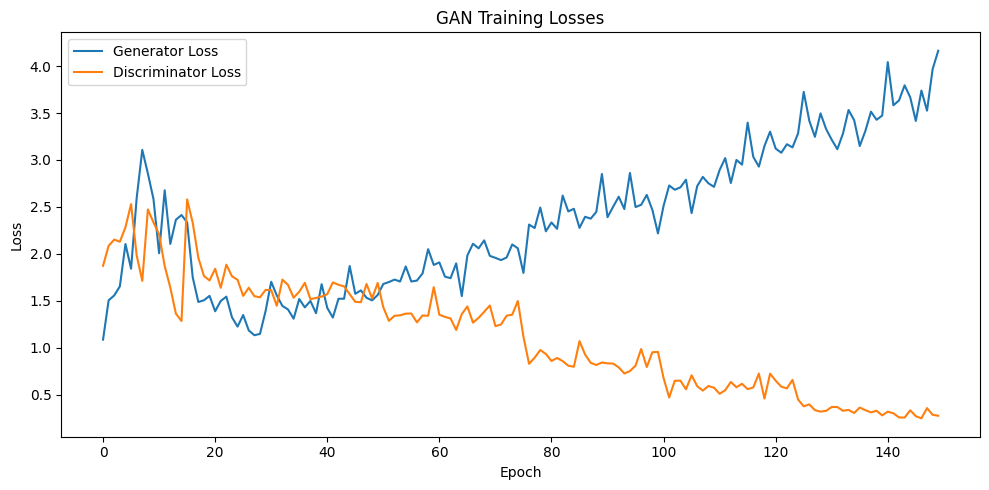

In [ ]:
def plot_losses(g_losses, d_losses):
    """
    Plot generator and discriminator losses.
    
    Args:
        g_losses (list): Generator losses
        d_losses (list): Discriminator losses
    """
    plt.figure(figsize=(10, 5))
    plt.plot(g_losses, label='Generator Loss')
    plt.plot(d_losses, label='Discriminator Loss')
    plt.title('GAN Training Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    
    # plt.savefig(os.path.join('training_losses.png'))
    plt.show()
    plt.close()
    
plot_losses(g_losses, d_losses)

In [ ]:
OUTPUT_PATH = '/kaggle/working/images' if IS_KAGGLE else './output_images'

# Create output directory
os.makedirs(OUTPUT_PATH, exist_ok=True)

# Function to generate final images
def generate_final_images(generator, num_images=7000, batch_size=10):
    print(f"Generating {num_images} Monet-style images...")
    
    total_batches = (num_images + batch_size - 1) // batch_size
    generated_count = 0
    
    for i in range(total_batches):
        current_batch_size = min(batch_size, num_images - generated_count)
        noise = tf.random.normal([current_batch_size, LATENT_DIM])
        
        generated_images = generator(noise, training=False)
        
        for j in range(current_batch_size):
            img = (generated_images[j].numpy() + 1) * 127.5
            img = img.astype(np.uint8)
            
            # Save image
            img_path = os.path.join(OUTPUT_PATH, f'monet_{generated_count:04d}.jpg')
            Image.fromarray(img).save(img_path)
            
            generated_count += 1
            
        if (i + 1) % 10 == 0 or (i + 1) == total_batches:
            print(f"Progress: {generated_count}/{num_images} images generated")
    
    print(f"Successfully generated {generated_count} images")


In [ ]:
# # Generate final images
print("Generating final Monet-style images...")
generate_final_images(generator, num_images=7000)

import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")


Generating final Monet-style images...
Generating 7000 Monet-style images...
Progress: 100/7000 images generated
Progress: 200/7000 images generated
Progress: 300/7000 images generated
Progress: 400/7000 images generated
Progress: 500/7000 images generated
Progress: 600/7000 images generated
Progress: 700/7000 images generated
Progress: 800/7000 images generated
Progress: 900/7000 images generated
Progress: 1000/7000 images generated
Progress: 1100/7000 images generated
Progress: 1200/7000 images generated
Progress: 1300/7000 images generated
Progress: 1400/7000 images generated
Progress: 1500/7000 images generated
Progress: 1600/7000 images generated
Progress: 1700/7000 images generated
Progress: 1800/7000 images generated
Progress: 1900/7000 images generated
Progress: 2000/7000 images generated
Progress: 2100/7000 images generated
Progress: 2200/7000 images generated
Progress: 2300/7000 images generated
Progress: 2400/7000 images generated
Progress: 2500/7000 images generated
Progres